# A notebook to to get true and predicted CTann and RUI for HRApop atlas datasets


## Goal

See [this GitHub issue](https://github.com/x-atlas-consortia/hra-pop/issues/100)


## Import libraries


In [62]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Load data


In [63]:
df = pd.read_csv("data/validation-v7-ctann-rui.csv")

## Prepare data for visualization and visualize


In [64]:
df

,sex,sample,rui_location,dataset,tool,modality,organ,organId,datasetVsRuiSim,datasetVsTopPredictedRuiSim,ruiVsTopPredictedRuiSim,datasetVsTopPredictedDatasetSim,ruiVsTopPredictedDatasetSim
0,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8a...,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,heart,UBERON:0000948,0.911356,0.917636,1.0,0.989803,0.983528
1,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8a...,https://api.cellxgene.cziscience.com/dp/v1/col...,celltypist,sc_transcriptomics,heart,UBERON:0000948,0.701952,0.925033,1.0,0.992152,0.981170
2,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8a...,https://api.cellxgene.cziscience.com/dp/v1/col...,popv,sc_transcriptomics,heart,UBERON:0000948,0.941554,0.971689,1.0,0.986041,0.988823
3,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7...,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,heart,UBERON:0000948,0.933921,0.978646,1.0,0.997048,0.983528
4,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7...,https://api.cellxgene.cziscience.com/dp/v1/col...,celltypist,sc_transcriptomics,heart,UBERON:0000948,0.474365,0.916703,1.0,0.997618,0.981170
...,...,...,...,...,...,...,...,...,...,...,...,...,...
892,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/e21afc3c-3a7c-4717-90d...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,spleen,UBERON:0002106,0.744703,0.744706,1.0,0.993484,0.910879
893,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/b2aca02c-9559-4869-b55...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,1.000000,1.000000,1.0,0.998475,0.998475
894,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/e43280c9-840b-481f-a8a...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,0.998475,0.998475,1.0,0.998733,1.000000
895,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/fb6bb0ea-5ba7-44e2-90a...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,0.913469,0.913469,1.0,0.985884,1.000000


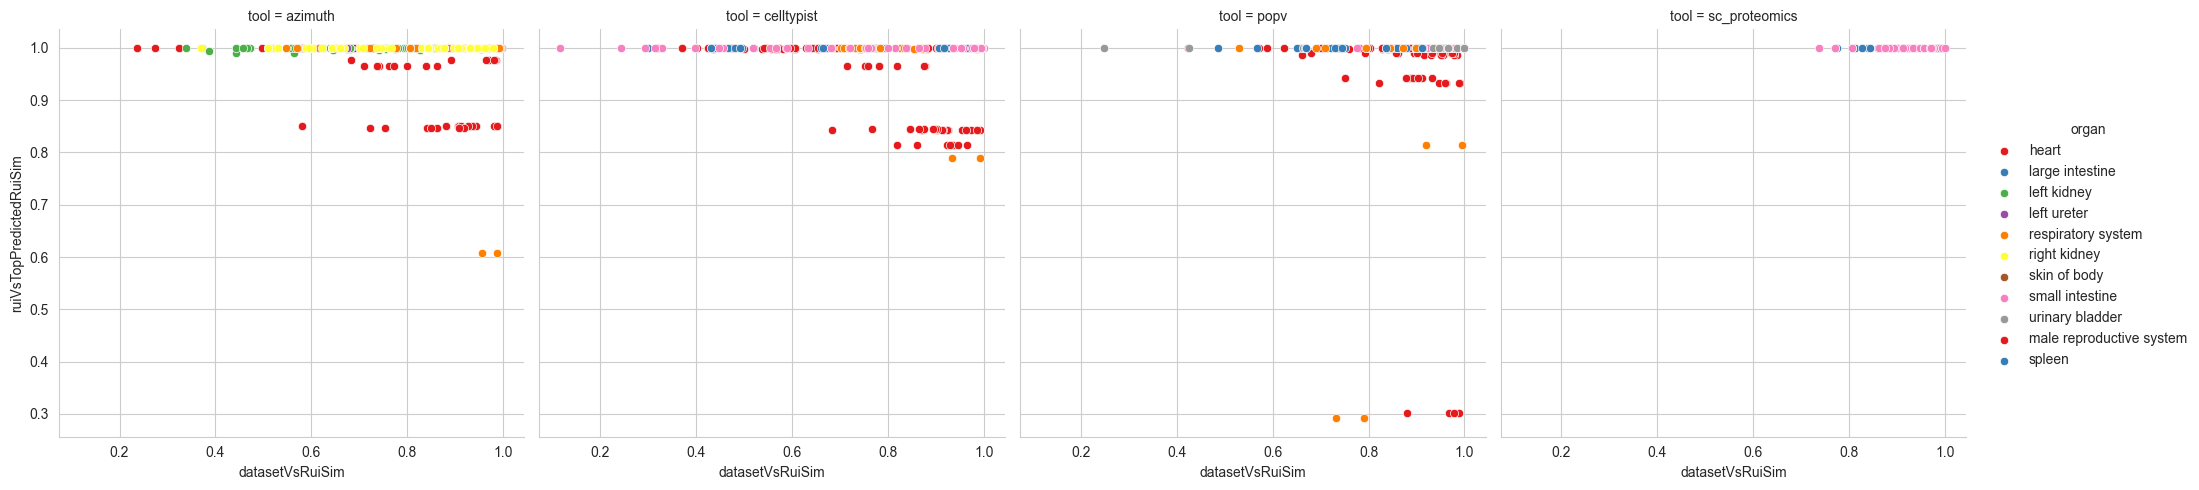

In [65]:
# Create a custom color palette
custom_palette = sns.color_palette("Set1")

# Create FacetGrid
g = sns.FacetGrid(df, col="tool", 
                  hue='organ', palette=custom_palette, height=5, aspect=1)

# Set the style of the plot
# Options: "white", "dark", "whitegrid", "darkgrid", "ticks"
sns.set_style("whitegrid")

# Create a scatter plot
g.map(sns.scatterplot, "datasetVsRuiSim",
      "ruiVsTopPredictedRuiSim")

# Add a legend
g.add_legend()
# Show the plot
plt.show()

## Data dictionary

| Axis | Variable | Explanation | 
|-- | --------- | ----------- | 
| x | datasetVsRuiSim | CTann (x axis) Cosine sim between TRUE cell summary of input dataset and PREDICTED cell summary of input RUI location (as computed by US 1) | 
| y | ruiVsPredictedRuiSim (with Andi's added compared AS tags) |  |